In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Preprocessing ASEC data and simulating response values

ASEC Data Source: https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html

There are household, family, and person level datasets. We'll use the person level.

If you'd like to run this notebook or try your own preprocessing approaches, please download the datafile yourself. It is a bit large for git and Canvas.

**Note:** If you do decide to try your own preprocessing, **please use the preprocessed data provided with the assignment for your analysis in the HW2 notebook for consistency.**

In [2]:
data = pd.read_csv('pppub24.csv',on_bad_lines='skip')

In [3]:
data.shape

(144265, 828)

There are many, many predictors. We've selected a subset.

The data dictionary is here: https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asec2024_ddl_pub_full.pdf

## Subset and rename predictors

In [4]:
# an incomplete list of some possible predictors
# more info in the data dictionary: https://www2.census.gov/programs-surveys/cps/datasets/2024/march/asec2024_ddl_pub_full.pdf
cols = {
#     Quantative
    'A_AGE' : 'age',
    'WKSWORK': 'weeks_worked',
    'HRSWK': 'hours_per_week', # hours worked last week
    'A_HRSPAY': 'hourly_pay', # hourly pay [Note: probably needs an interaction term as 0=not paid by hour]
    
#     Qualitative
    'A_FTPT': 'student_status', # full-time enrollement (3 classes)
    'A_HGA': 'education', # educational attainment (17 classes) [not quite qualitative]
    'A_MARITL': 'marital_status', # marital status (7 classes)
    'A_SEX': 'sex', # sex (2 classes)
    'PEAFEVER': 'military_service', # served in military (3 classes)
    'PRDTRACE': 'race', # race (26 classes)
    'A_MJIND': 'industry', # industry (work) code (17 classes)
    'A_MJOCC': 'occupation', # major occupation code (12 classes)
    'A_HRLYWK': 'is_paid_by_hour', # is paied by hour (3 classes)
    'PRPERTYP': 'person_record',
    
    'PTOT_R': 'income' 
}

# to predict
response = 'income' # total person income (41 'buckets')

#### Renaming columns for readability

In [5]:
df = data[list(cols.keys())]
df.columns = list(cols.values())
df.head()

,age,weeks_worked,hours_per_week,hourly_pay,student_status,education,marital_status,sex,military_service,race,industry,occupation,is_paid_by_hour,person_record,income
0,85,0,0,-1,0,39,1,2,2,1,0,0,0,2,4
1,85,0,0,-1,0,39,1,1,1,1,0,0,0,2,10
2,15,0,0,-1,0,34,7,2,-1,1,0,0,0,2,1
3,53,0,0,-1,0,39,1,2,2,1,0,0,0,2,5
4,52,52,42,-1,0,40,1,1,2,1,5,5,0,2,17


## Data set pre-processing 

In [6]:
# filter out children / anyone younger than 18
df = df[(df.person_record != 1) & (df.age >= 18)]

In [7]:
df.shape

(109367, 15)

The income response (PTOT_R/income) as described in the data dictionary consists of 42 'buckets'

The first bucket (0) corresponds to no income. Buckets 1-40 are increments of \\$5,000. The final bucket is all incomes > \\$100,000. You can see this bucket has many entries because incomes are in reality very right skrewed with have a long tail.

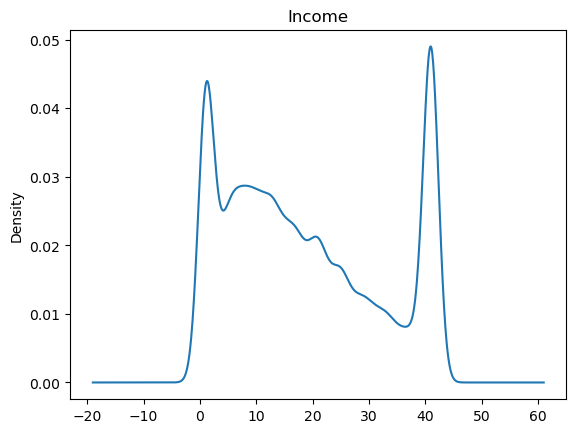

In [8]:
df.income.plot(kind='kde', title='Income');

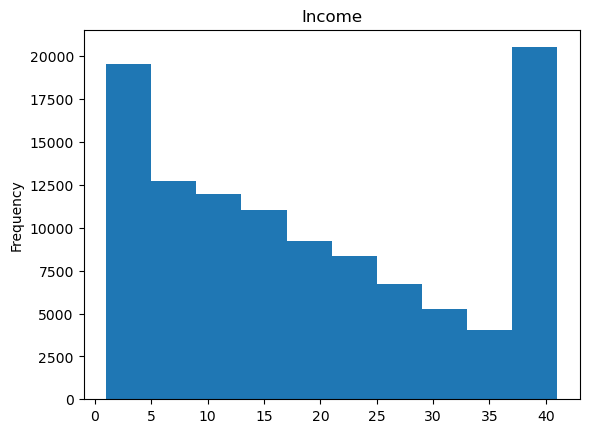

In [9]:
df.income.plot(kind='hist', title='Income');

**Simulate incomes**

Bucket 0 has no income.

For each observation buckets 1-40 we sample from a uniform distribution that spans the bucket's range.

For the final bucket (41) we use an exponential distribution. This gives us something that looks more like what we think the true income distribution looks like.

In [10]:
def income_convert(label):
    if label == 0:
        income = 0
    elif label == 41:
        # filthy rich people in the tail
        income = 100_000 + 5_000 * np.random.exponential(scale=2.5)
    else:
        interval = 2500
        income = np.random.uniform((label-1)*interval, label*interval-1)
        income = np.round(income, 2)
    return income

Subset predictors for our $X$ and use sampling to make response $y$ more continuous.

In [11]:
np.random.seed(109)
df[response] = df[response].apply(income_convert)

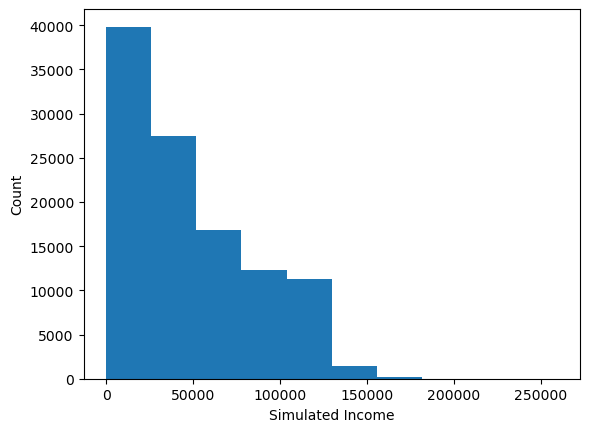

In [12]:
plt.hist(df[response])
ax = plt.gca()
ax.set_xlabel('Simulated Income')
ax.set_ylabel('Count');

## Reduce categorical values

Since many attributes have many unique values, we merge several of them together.
For instance, the original dataset had 26 options for race, where there were 5 unique single races, and many options for people identifying as mixed race. To deal with this complexity we decided to join all race options that were mixes between 3 or more races. This was also motivated by the relatively small amount of people identifying as belonging to these groups. 

This step was taken for the sake of simplicity in the homework. It is worth considering that many datasets you access have already undergone similar sorts of reduction. The difference there being that you as the end user may not know what the data looked like originally!

In [13]:
# Colapse merge for easier interpretation
df.loc[df['race']>= 16, 'race'] = 16
for i in range(16):
    df.loc[df["race"]==(1+i) , 'race'] =i

# covert military service to a binary variable
df.loc[df["military_service"] != 1, 'military_service' ] = 0
# Only 2 unique values in original dataset
# so this is not a reduction but a relabeling (1,2) -> (1,0)
df.loc[df["sex"] != 1, 'sex' ] = 0

# Colapse marriage status (all married together)
df.loc[df["marital_status"] <= 3, 'marital_status'] =0
for i in range(4):
    df.loc[df["marital_status"]==(4+i) , 'marital_status'] =i+1

# Education 
# not graduated high school
df.loc[df['education'].isin([31, 32,33,34,35, 36, 37, 38]) , 'education'] = 0

# high school graduate 
df.loc[df['education'].isin([39, 40]) , 'education'] = 1

# associate degree 
df.loc[df['education'].isin([41, 42]) , 'education'] = 2

# Bachelor's degree (for example: BA,AB,BS)
df.loc[df['education'].isin([43]) , 'education'] = 3

# Master's degree (for example: MA,MS,MENG,MED,MSW, MBA)
df.loc[df['education'].isin([44]) , 'education'] = 4

# Professional school degree (for example: MD,DDS,DVM,LLB,JD)
df.loc[df['education'].isin([45]) , 'education'] = 5

# Doctorate degree (for example: PHD,EDD)
df.loc[df['education'].isin([46]) , 'education'] = 6

In [14]:
# no missing response values
assert sum(df[response].isna()) == 0

In [15]:
# no missing values in predictors
assert df.isna().sum().sum() == 0

In [16]:
# Inspect our dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 109367 entries, 0 to 144261
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               109367 non-null  int64  
 1   weeks_worked      109367 non-null  int64  
 2   hours_per_week    109367 non-null  int64  
 3   hourly_pay        109367 non-null  int64  
 4   student_status    109367 non-null  int64  
 5   education         109367 non-null  int64  
 6   marital_status    109367 non-null  int64  
 7   sex               109367 non-null  int64  
 8   military_service  109367 non-null  int64  
 9   race              109367 non-null  int64  
 10  industry          109367 non-null  int64  
 11  occupation        109367 non-null  int64  
 12  is_paid_by_hour   109367 non-null  int64  
 13  person_record     109367 non-null  int64  
 14  income            109367 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 13.4 MB


,age,weeks_worked,hours_per_week,hourly_pay,student_status,education,marital_status,sex,military_service,race,industry,occupation,is_paid_by_hour,person_record,income
0,85,0,0,-1,0,1,0,0,0,0,0,0,0,2,9028.04
1,85,0,0,-1,0,1,0,1,1,0,0,0,0,2,23728.07
3,53,0,0,-1,0,1,0,0,0,0,0,0,0,2,11747.51
4,52,52,42,-1,0,1,0,1,0,0,5,5,0,2,40486.23
5,68,0,0,-1,0,0,1,1,0,0,0,0,0,2,9436.61


### Store the changed df in a new significantly smaller file

In [17]:
df.to_csv("census_data.csv") 

## Results

- **age** - Age of person 
- **hourly_pay** - Hourly salary of person (-1 if person is not payed by the hour)
- **hours_per_week** - Number of hours usually worked per week
- **weeks_worked** - Number of weeks worked per year

- **sex** - {'Female': 0,'Male': 1} 
- **marital_status** - {'married':0,'widowed':1,'Divorced':2, 'Separated':3,'Never married':4}
- **military_service** - {'has not served in the US armed forces':0,'has served in the US armed forces':1}
- **student_status** - {'Not currently studying':0,'Enrolled full-time':1, 'Enrolled part-time':1}
- **education** - {'Not finished high school': 0, 'High school': 1, 'Associate degree': 2, 'Bachelor\'s': 3, ,'Master\'s': 4,'Professional school degree': 5', Doctorate': 6}

- **race** - {'White': 0, 'Black': 1, 'American Indian, Alaskan Native only (AI)': 2, 'Asian': 3, ,'Hawaiian, Pacific Islander (HP)': 4,'White-Black': 5', 'White-AI': 6, 'White-Asian': 7, 'White-HP': 8, 'Black-AI': 9, 'Black-Asian': 10, 'Black-HP': 11, 'AI-Asian': 12, 'AI-HP': 13, 'Asian-HP': 14, 'other race combinations': 15}

- **industry** - Industry that the person is working in {'Other': 0, 'Agriculture, forestry, fishing, hunting': 1, 'Mining': 2, 'Construction': 3, ,'Manufacturing': 4,'Wholesale and retail trade': 5','Transportation and utilities': 6, 'Information': 7, 'Financial activities': 8, 'Professional and business services': 9, 'Education and health services': 10, 'Leisure and hospitality': 11, 'Other services': 12, 'Public administration': 13, 'Armed Forces': 14}

- **industry** - Industry that the person is working in {'Other': 0, 'Agriculture, forestry, fishing, hunting': 1, 'Mining': 2, 'Construction': 3, ,'Manufacturing': 4,'Wholesale and retail trade': 5','Transportation and utilities': 6, 'Information': 7, 'Financial activities': 8, 'Professional and business services': 9, 'Education and health services': 10, 'Leisure and hospitality': 11, 'Other services': 12, 'Public administration': 13, 'Armed Forces': 14}

- **occupation** - Occupation of person {'Other': 0, 'Management, business, and financial occ.': 1, 'Professional and related occ.': 2, 'Service occ.': 3, ,'Sales and related occ.': 4,'Office and administrative support occ.': 5','Farming, fishing and forestry': 6, 'Construction and extraction occ.': 7, 'Installation, maintenance and repair occ.': 8, 'Production occ.': 9, 'Transportation and material moving occ.': 10, 'Armed Forces': 11}


- **income** - Annual income in dollars